# robotdog

In [1]:
import tensorflow as tf
from tensorflow import keras
import io
import os
import tensorboard

# Define the keras tensorboard callback
from datetime import datetime

logdir = "./logs/" + datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
#from keras import backend as K
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#K.set_image_dim_ordering('th')
# setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

# matplotlib inline
plt.style.use('ggplot')

def readData(filePath):
    # attributes of the dataset
    columnNames = ['label','time','x','y','z']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data

dataset = readData('./datasets/data-robotdog.txt')
label = LabelEncoder()
dataset['label_num'] = label.fit_transform(dataset['label'])

print(dataset)



           label           time        x        y        z  label_num
0       standing  1606186215535  4.70719 -7.13924 -0.47072          3
1       standing  1606186215546  4.74642 -7.10001 -0.47072          3
2       standing  1606186215557  4.66797 -7.02156 -0.43149          3
3       standing  1606186215569  4.74642 -7.06079 -0.47072          3
4       standing  1606186215580  4.74642 -7.10001 -0.43149          3
...          ...            ...      ...      ...      ...        ...
11995  handstand  1606191161572 -8.08068 -3.45194 -0.23536          1
11996  handstand  1606191161574 -8.08068 -3.45194 -0.23536          1
11997  handstand  1606191161576 -8.08068 -3.45194 -0.23536          1
11998  handstand  1606191161578 -8.08068 -3.45194 -0.23536          1
11999  handstand  1606191161580 -8.08068 -3.45194 -0.23536          1

[12000 rows x 6 columns]


In [3]:
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)

def plotActivity(labelName,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['time'],data['x'],'x')
    plotAxis(ax1,data['time'],data['y'],'y')
    plotAxis(ax2,data['time'],data['z'],'z')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(labelName)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [4]:
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)

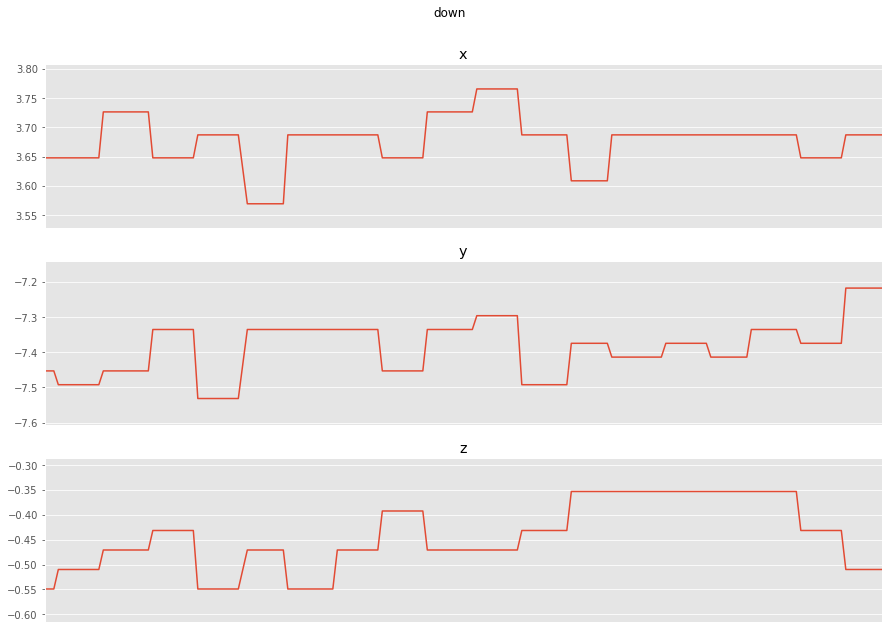

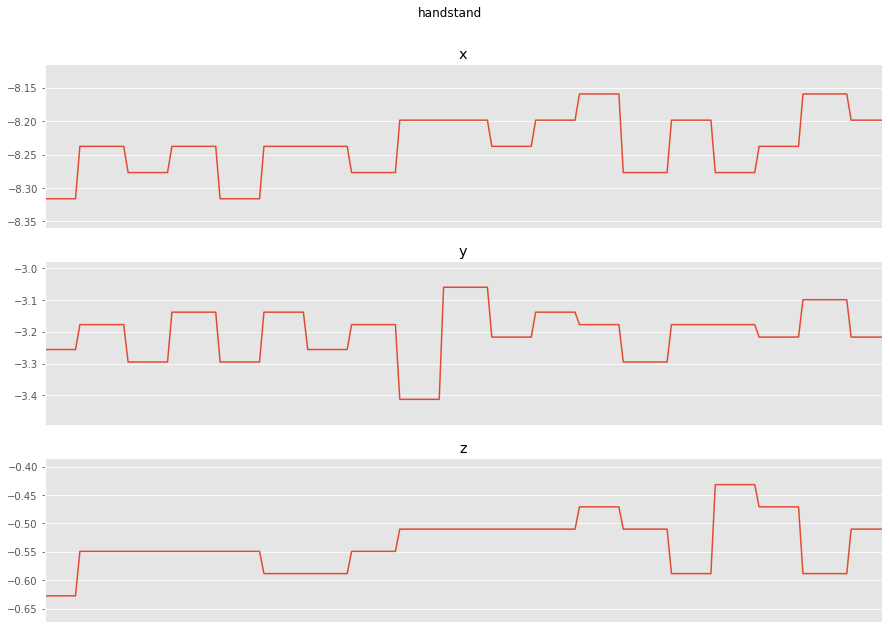

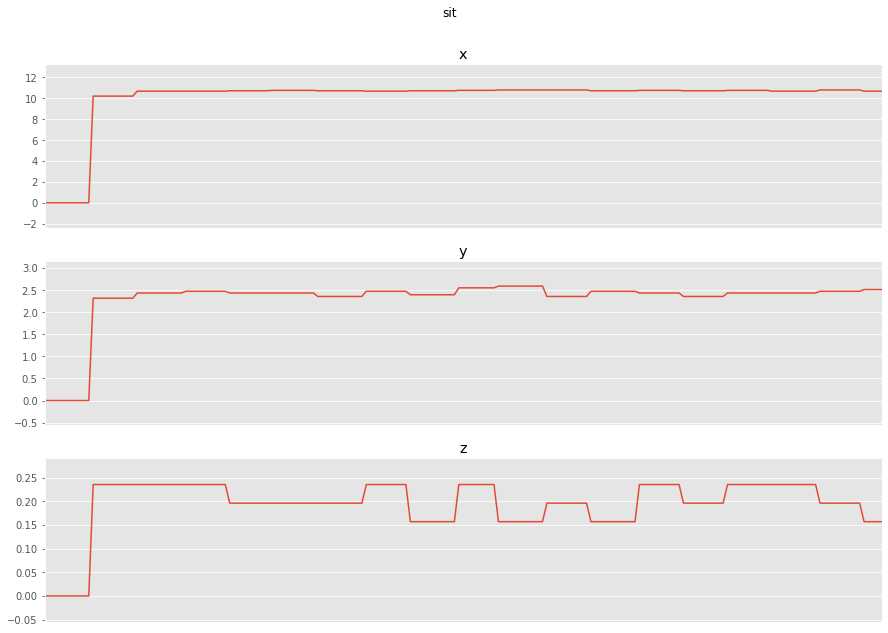

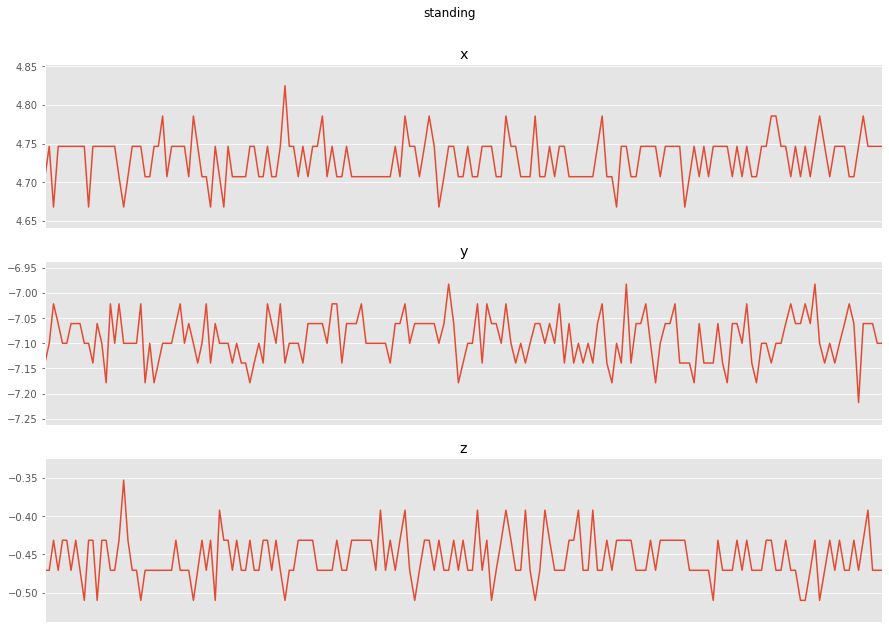

In [5]:
# segmenting the time series
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= []
    
    for (start, end) in windows(data['time'],window_size):
        x = data['x'][start:end]
        y = data['y'][start:end]
        z = data['z'][start:end]
        if(len(data['time'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            #labels = np.append(labels,stats.mode(data['label_num'][start:end])[0][0])
            labels.append(stats.mode(data['label_num'][start:end])[0][0])
    labels = np.asarray(labels)
    
    return segments, labels

# plotting a subset of the data to visualize
for labelName in np.unique(dataset['label']):
    subset = dataset[dataset['label']==labelName][:180]
    plotActivity(labelName,subset)
# segmenting the signal in overlapping windows of 90 samples with 50% overlap
segments, labels = segment_signal(dataset) 


### 파라미터 설정

In [6]:
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# split ratio for test and validation
trainSplitRatio = 0.8
# number of epochs
epochs = 10
# batchsize
batchSize = 20
# number of total clases
numClasses = len(label.classes_)
# dropout ratio for dropout layer
dropOutRatio = 0.2
# reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
# splitting in training and testing data

trainX, testX, trainY, testY = train_test_split(reshapedSegments, labels, test_size = 0.2, random_state = 0)

#trainSplit = np.random.rand(len(reshapedSegments)) < trainSplitRatio
#trainX = reshapedSegments[trainSplit]
#testX = reshapedSegments[~trainSplit]
#trainX = np.nan_to_num(trainX)
#testX = np.nan_to_num(testX)
#trainY = labels[trainSplit]
#testY = labels[~trainSplit]


print(testY)

[0 0 2 3 1 1 3 0 2 2 2 0 1 1 2 3 1 2 3 1 0 2 2 3 1 0 0 1 3 2 1 0 3 3 3 0 2
 3 1 3 0 2 1 1 3 3 3 2 3 1 0 1 0]


In [7]:
print('train start')


def cnnModel():
    model = Sequential()
    # adding the first convolutionial layer with 32 filters and 5 by 5 kernal size, using the rectifier as the activation function
    model.add(Conv2D(numFilters, (kernalSize1,kernalSize1),input_shape=(numOfRows, numOfColumns,1),activation='relu'))
    # adding a maxpooling layer
    model.add(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid'))
    # adding a dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    # flattening the output in order to apply the fully connected layer
    model.add(Flatten())
    # adding first fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    #adding second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    # adding softmax layer for the classification
    model.add(Dense(4, activation='softmax'))
    # Compiling the model to generate a model
    adam = optimizers.Adam(lr = 0.001, decay=1e-6)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model


train start


In [8]:
model = cnnModel()

# Confusion Matrix

In [9]:
import sklearn.metrics
#from mlxtend.plotting import plot_confusion_matrix
#from sklearn.metrics import confusion_matrix


In [10]:
file_writer_cm = tf.summary.create_file_writer(logdir+'/cm')

In [11]:
def plot_to_image(figure):
    # Save the plot to a PNG in memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image,0)
    return image

In [12]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [13]:
def log_confusion_matrix(epochs, logs):
    predY = model.predict_classes(testX)
    cm = sklearn.metrics.confusion_matrix(testY, predY)
    figure = plot_confusion_matrix(cm, class_names=label.classes_)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image('Confusion Matrix', cm_image, step=epochs)

cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
        

# Model Fit

In [14]:
for layer in model.layers:
    print(layer.name)

#history = model.fit(trainX, trainY, epochs=epochs, validation_data=(testX, testY), verbose=1)
history=model.fit(trainX,trainY, validation_data= (testX, testY),epochs=epochs,batch_size=batchSize,verbose=2, callbacks=[tensorboard_callback, cm_callback])
score = model.evaluate(testX,testY,verbose=2)
print('Baseline Error: %.2f%%' %(100-score[1]*100))
model.save('model_robotdog.h5')

conv2d
max_pooling2d
dropout
flatten
dense
dense_1
dense_2
Epoch 1/10
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
11/11 - 1s - loss: 0.6578 - accuracy: 0.6745 - val_loss: 0.2303 - val_accuracy: 0.9811
Epoch 2/10
11/11 - 0s - loss: 0.2239 - accuracy: 0.9104 - val_loss: 0.2250 - val_accuracy: 0.7547
Epoch 3/10
11/11 - 0s - loss: 0.2124 - accuracy: 0.8915 - val_loss: 0.1698 - val_accuracy: 0.9811
Epoch 4/10
11/11 - 0s - loss: 0.0643 - accuracy: 0.9953 - val_loss: 0.1834 - val_accuracy: 0.9811
Epoch 5/10
11/11 - 0s - loss: 0.0535 - accuracy: 0.9953 - val_loss: 0.2122 - val_accuracy: 0.9811
Epoch 6/10
11/11 - 0s - loss: 0.0330 - accuracy: 0.9953 - val_loss: 0.2047 - val_accuracy: 0.9811
Epoch 7/10
11/11 - 

# Learning Curve graph

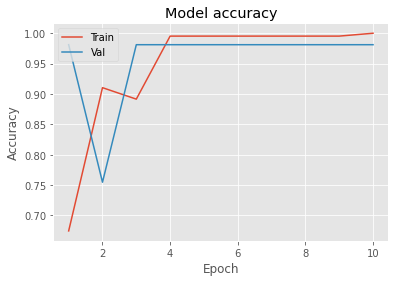

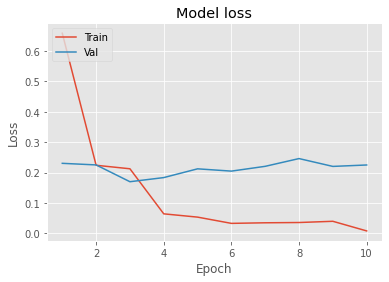

In [15]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, epochs)

# 원본

           label           time        x        y        z
0       standing  1606186215535  4.70719 -7.13924 -0.47072
1       standing  1606186215546  4.74642 -7.10001 -0.47072
2       standing  1606186215557  4.66797 -7.02156 -0.43149
3       standing  1606186215569  4.74642 -7.06079 -0.47072
4       standing  1606186215580  4.74642 -7.10001 -0.43149
...          ...            ...      ...      ...      ...
11995  handstand  1606191161572 -8.08068 -3.45194 -0.23536
11996  handstand  1606191161574 -8.08068 -3.45194 -0.23536
11997  handstand  1606191161576 -8.08068 -3.45194 -0.23536
11998  handstand  1606191161578 -8.08068 -3.45194 -0.23536
11999  handstand  1606191161580 -8.08068 -3.45194 -0.23536

[12000 rows x 5 columns]


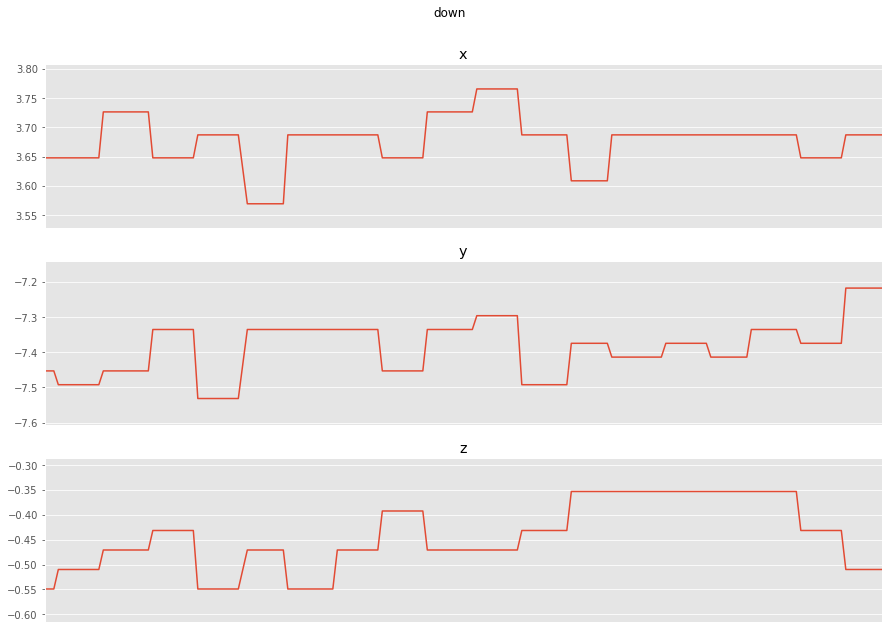

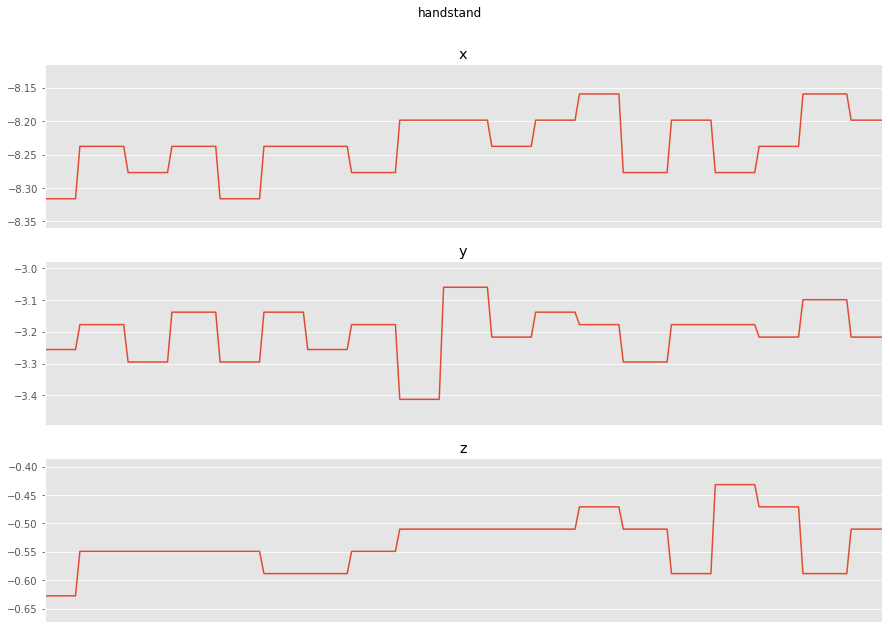

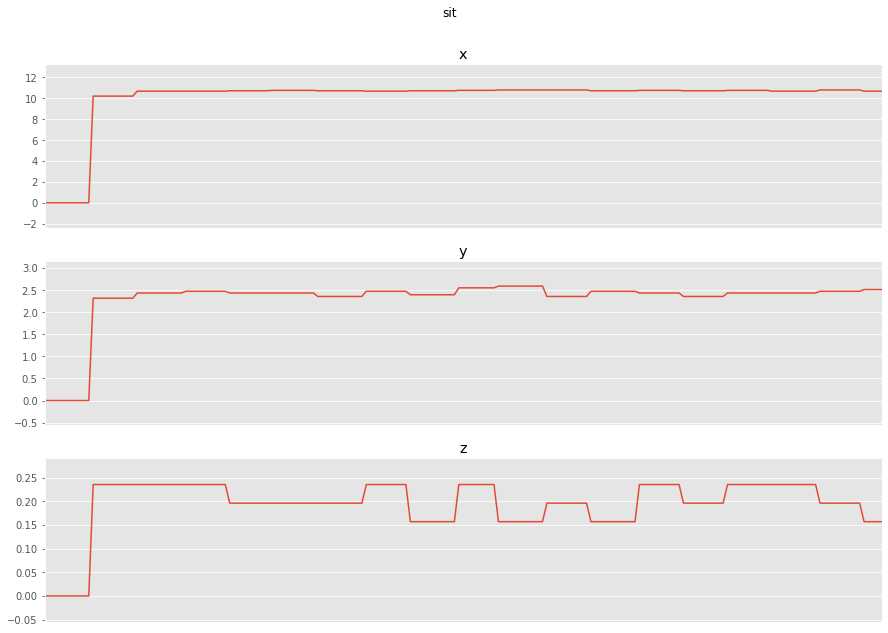

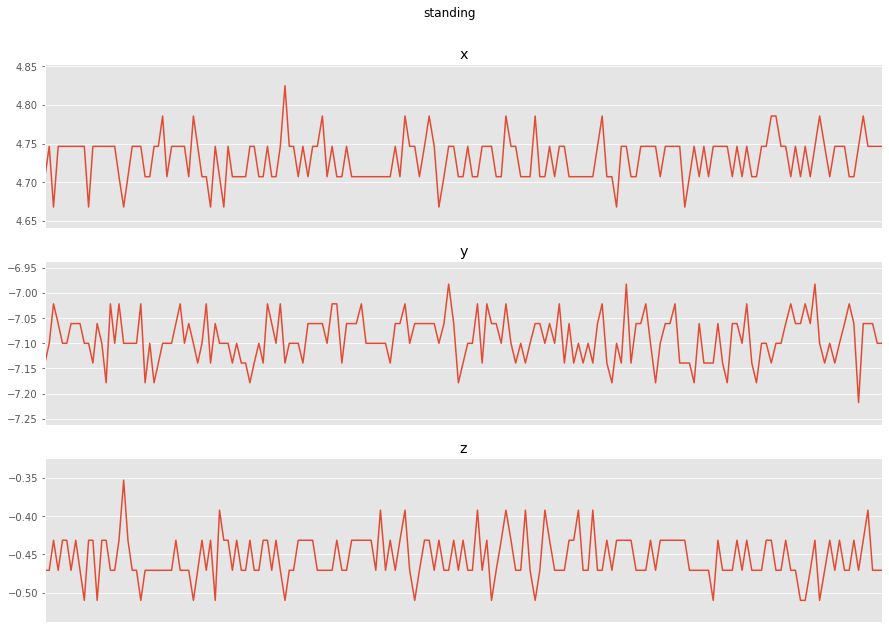

train start


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
#from keras import backend as K
from keras import optimizers
#K.set_image_dim_ordering('th')
# setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

# matplotlib inline
plt.style.use('ggplot')
# defining function for loading the dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['label','time','x','y','z']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    print(data)
    return data
# defining a function for feature normalization
# (feature - mean)/stdiv
def featureNormalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset-mu)/sigma
# defining the function to plot a single axis data
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)
# defining a function to plot the data for a given activity
def plotActivity(labelName,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['time'],data['x'],'x')
    plotAxis(ax1,data['time'],data['y'],'y')
    plotAxis(ax2,data['time'],data['z'],'z')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(labelName)
    plt.subplots_adjust(top=0.9)
    plt.show()
# defining a window function for segmentation purposes
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)
# segmenting the time series
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0))
    for (start, end) in windows(data['time'],window_size):
        x = data['x'][start:end]
        y = data['y'][start:end]
        z = data['z'][start:end]
        if(len(data['time'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data['label'][start:end])[0][0])
    return segments, labels
''' Main Code '''
# # # # # # # # #   reading the data   # # # # # # # # # # 
# Path of file #
dataset = readData('./datasets/data-robotdog.txt')

# plotting a subset of the data to visualize
for labelName in np.unique(dataset['label']):
    subset = dataset[dataset['label']==labelName][:180]
    plotActivity(labelName,subset)
# segmenting the signal in overlapping windows of 90 samples with 50% overlap
segments, labels = segment_signal(dataset) 
#categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)
# defining parameters for the input and network layers
# we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# split ratio for test and validation
trainSplitRatio = 0.8
# number of epochs
epochs = 10
# batchsize
batchSize = 10
# number of total clases
numClasses = labels.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2
# reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
# splitting in training and testing data
trainSplit = np.random.rand(len(reshapedSegments)) < trainSplitRatio
trainX = reshapedSegments[trainSplit]
testX = reshapedSegments[~trainSplit]
trainX = np.nan_to_num(trainX)
testX = np.nan_to_num(testX)
trainY = labels[trainSplit]
testY = labels[~trainSplit]

print('train start')

def cnnModel():
    model = Sequential()
    # adding the first convolutionial layer with 32 filters and 5 by 5 kernal size, using the rectifier as the activation function
    model.add(Conv2D(numFilters, (kernalSize1,kernalSize1),input_shape=(numOfRows, numOfColumns,1),activation='relu'))
    # adding a maxpooling layer
    model.add(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid'))
    # adding a dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    # flattening the output in order to apply the fully connected layer
    model.add(Flatten())
    # adding first fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    #adding second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    # adding softmax layer for the classification
    model.add(Dense(numClasses, activation='softmax'))
    # Compiling the model to generate a model
    adam = optimizers.Adam(lr = 0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model


In [25]:
model = cnnModel()

for layer in model.layers:
    print(layer.name)
history=model.fit(trainX,trainY, validation_split=1-trainSplitRatio,epochs=epochs,batch_size=batchSize,verbose=2, callbacks=[tensorboard_callback])
score = model.evaluate(testX,testY,verbose=2)
print('Baseline Error: %.2f%%' %(100-score[1]*100))
model.save('model_robotdog.h5')

conv2d_1
max_pooling2d_1
dropout_1
flatten_1
dense_3
dense_4
dense_5
Epoch 1/10
18/18 - 0s - loss: 0.7857 - accuracy: 0.7062 - val_loss: 0.4496 - val_accuracy: 0.6222
Epoch 2/10
18/18 - 0s - loss: 0.2135 - accuracy: 0.9209 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 3/10
18/18 - 0s - loss: 0.1536 - accuracy: 0.9435 - val_loss: 0.0568 - val_accuracy: 1.0000
Epoch 4/10
18/18 - 0s - loss: 0.0488 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 5/10
18/18 - 0s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9778
Epoch 6/10
18/18 - 0s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 0.9778
Epoch 7/10
18/18 - 0s - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9778
Epoch 8/10
18/18 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 0.9778
Epoch 9/10
18/18 - 0s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9778
Epoch 10/10
18/18 - 0s - loss: 0.0016 - accuracy:

In [9]:
testX.shape

(43, 90, 3, 1)

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 89, 2, 128)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 1, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 1, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               721024    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                